In [1]:
%load_ext autoreload
%autoreload 2

In [44]:
%matplotlib inline  

import sys

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

sys.path.append('..')
from utils import *
from data import *
from plotting import *

In [6]:
import matplotlib as mpl
# mpl.rcParams['figure.dpi']= 100

sns.set(style='ticks')
sns.set_palette('cubehelix')

In [7]:
kids_x_sdss = process_kids('/media/snakoneczny/data/KiDS/DR4/KiDS.DR4.x.SDSS.DR14.fits', sdss_cleaning=True)

Data shape: (152244, 47)
Droping NANs: 130777 (85.90%) left
Removing errors bigger than 1: 129111 (84.81%) left
Removing GAAP flags: 129111 left
Removing IMA flags: 128675 (84.52%) left
Cleaning SDSS: 121323 left


In [9]:
kids = process_kids('/media/snakoneczny/data/KiDS/DR4/KiDS.DR4.500k.fits')

Data shape: (501754, 42)
Droping NANs: 226903 (45.22%) left
Removing errors bigger than 1: 167995 (33.48%) left
Removing GAAP flags: 167995 left
Removing IMA flags: 167886 (33.46%) left


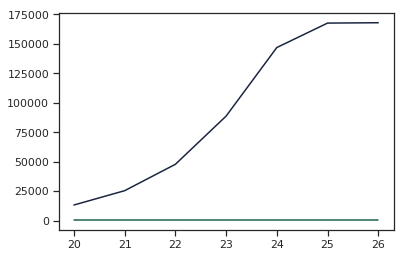

In [16]:
# Data cuts
r_max = kids[MAG_GAAP_STR.format('r')].max()
size_max = kids.shape[0]
x = range(20, int(r_max) + 1, 1)
y = [kids.loc[kids[MAG_GAAP_STR.format('r')] < r_m].shape for r_m in range(20, int(r_max) + 1, 1)]
plt.plot(x, y)

# KiDS and SDSS feature histograms

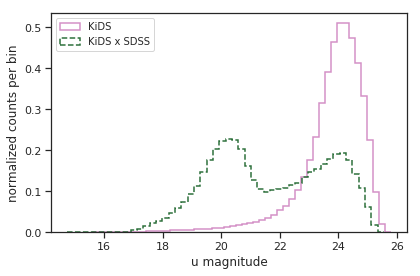

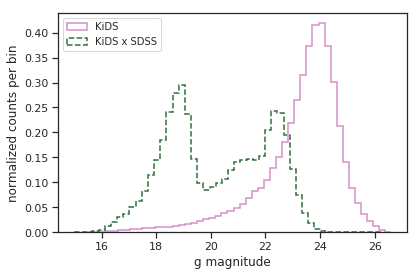

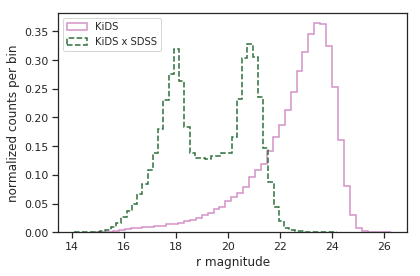

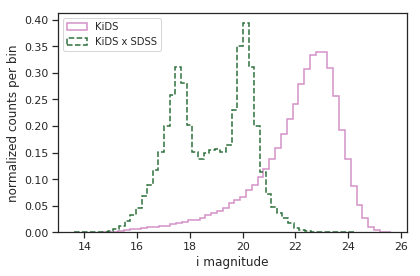

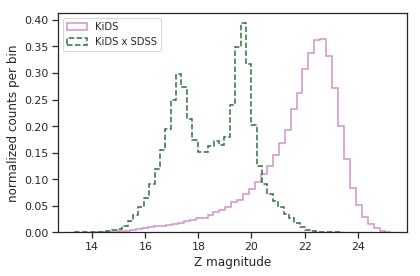

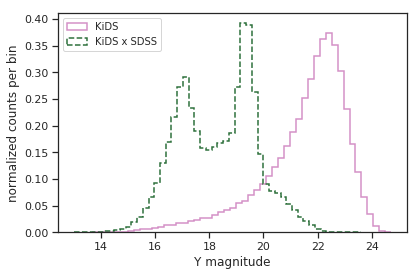

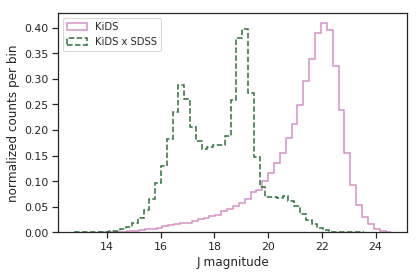

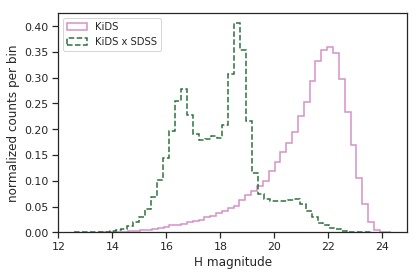

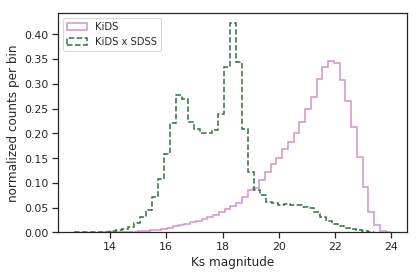

In [17]:
# Magnitude histograms
data_dict = OrderedDict([('KiDS', kids), ('KiDS x SDSS', kids_x_sdss)])
plot_histograms(data_dict, BAND_COLUMNS, legend_size=10, pretty_print_function=pretty_print_feature)

[autoreload of data failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 368, in superreload
    module = reload(module)
  File "/usr/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/usr/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "../data.py", line 83, in <module>
    RATIO_COLUMNS = get_ratio_cols(get_all_pairs(BANDS))
  File "../data.py", line 57, in get_ratio_cols
    return [get_ratio_str.format(band_1, band_2) for band_1, band_2 in band_tuples]
  File "../data

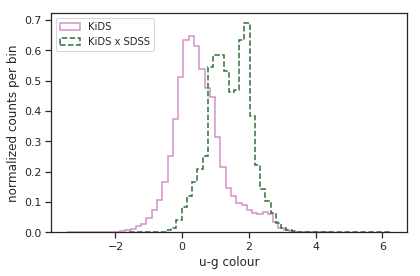

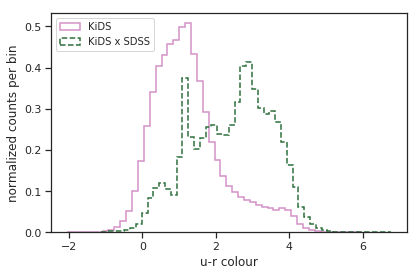

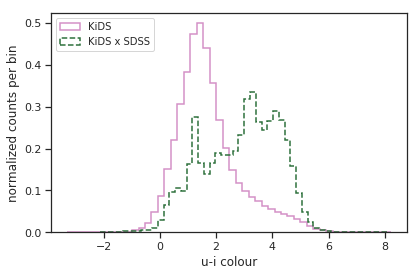

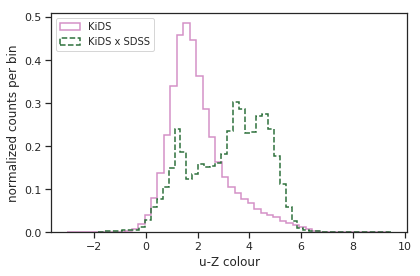

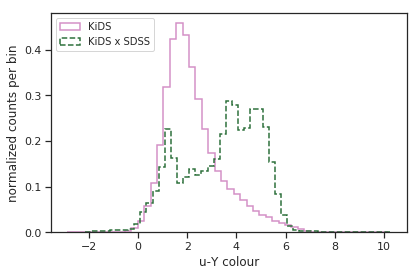

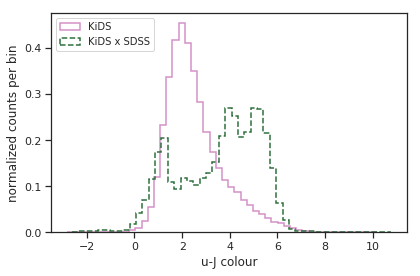

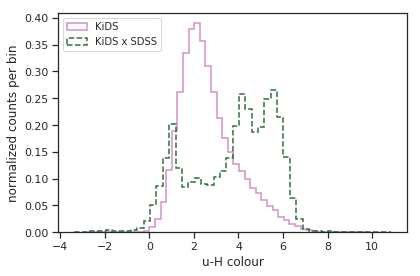

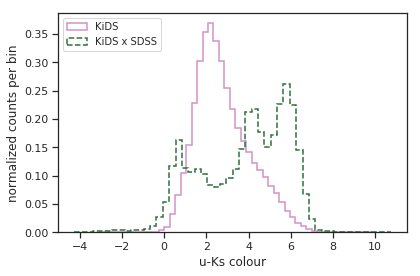

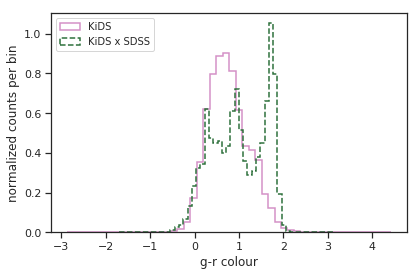

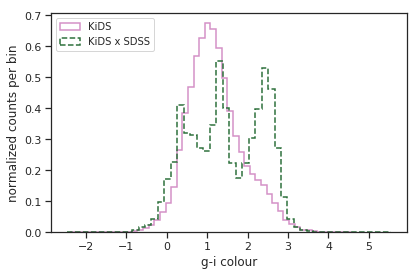

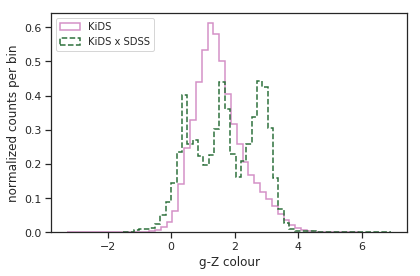

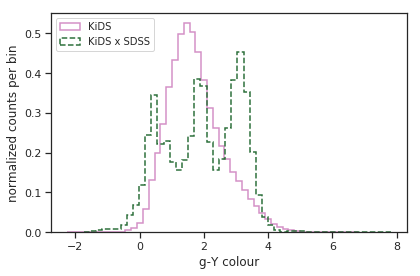

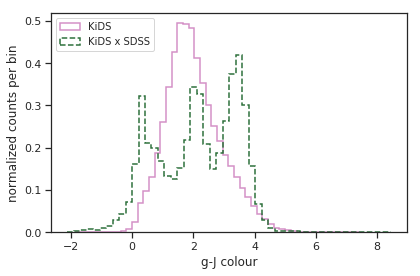

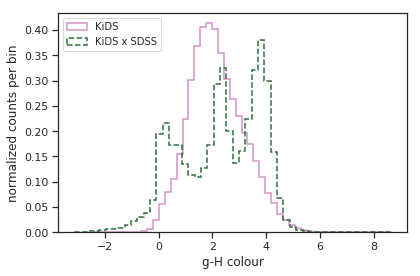

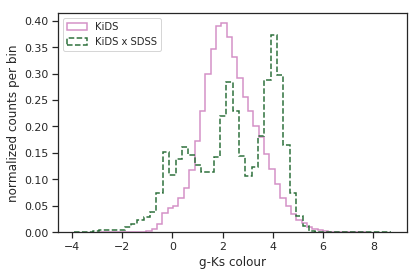

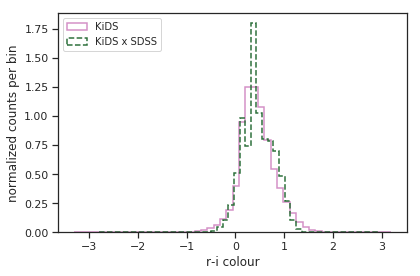

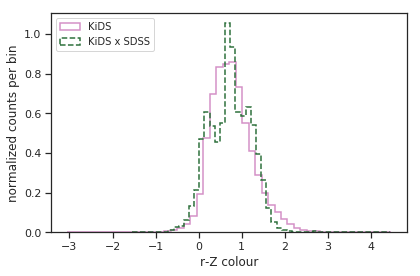

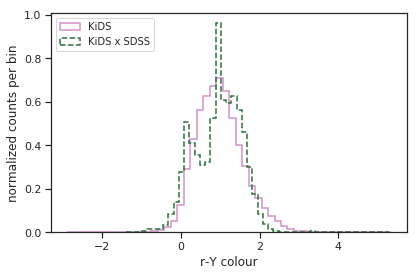

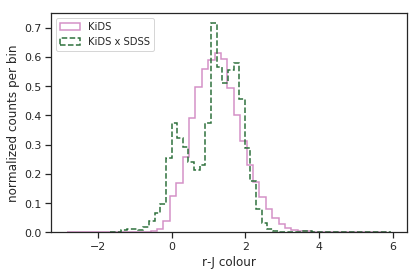

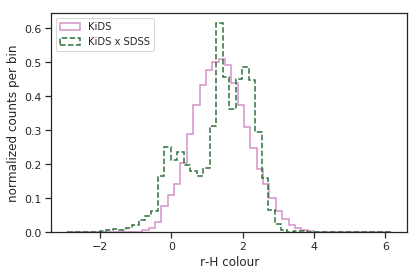

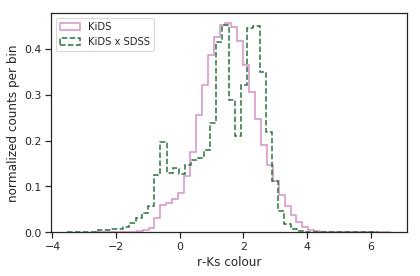

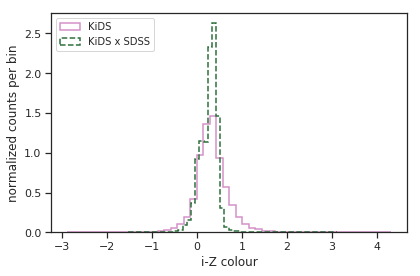

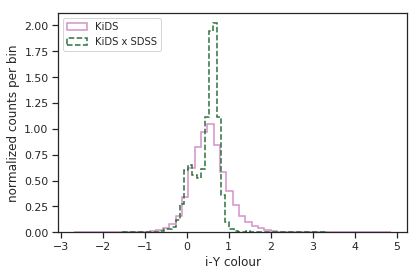

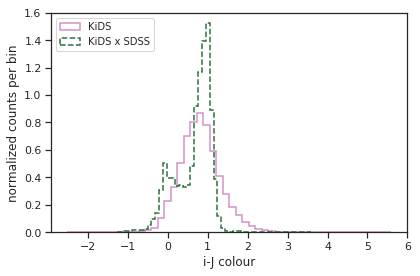

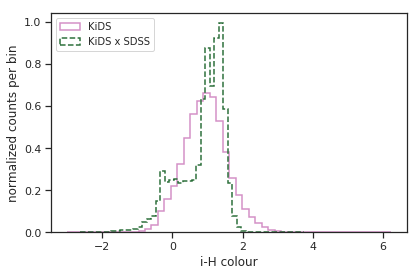

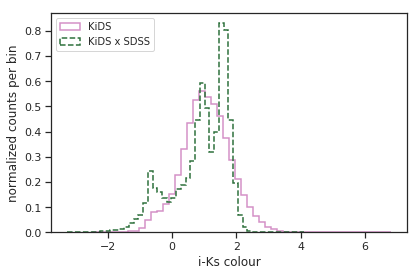

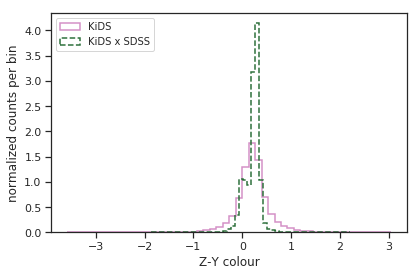

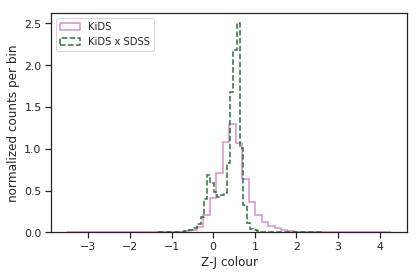

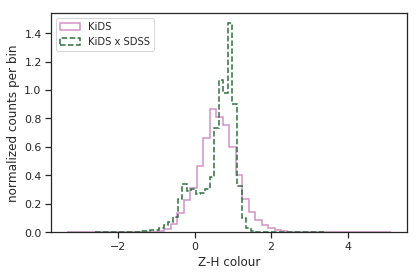

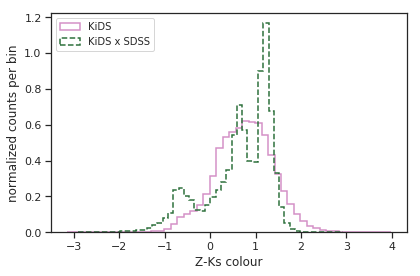

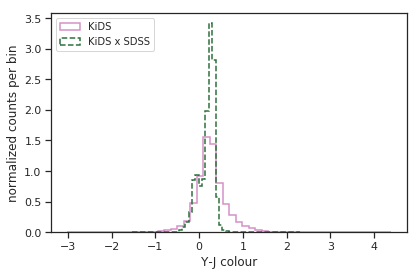

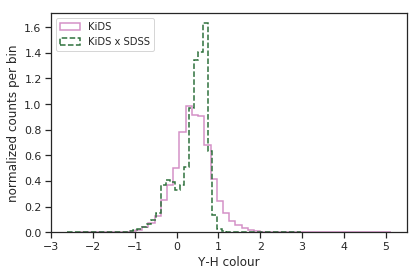

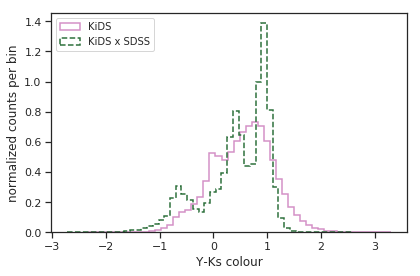

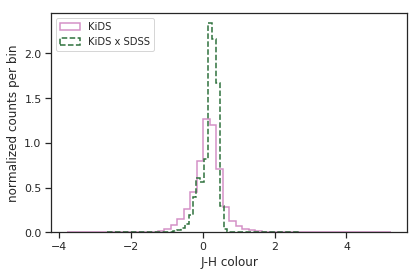

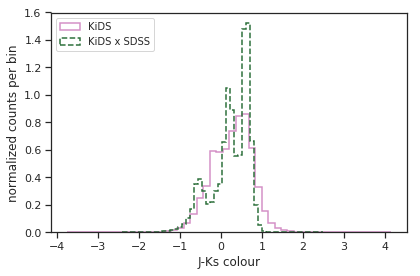

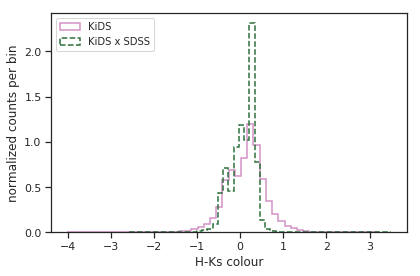

In [19]:
# Color histograms
data_dict = OrderedDict([('KiDS', kids), ('KiDS x SDSS', kids_x_sdss)])
#x_lim_dict = {COLOR_GAAP_STR.format('u', 'g'': (-2, 4)}
plot_histograms(data_dict, COLOR_COLUMNS, legend_size=10, pretty_print_function=pretty_print_feature)

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


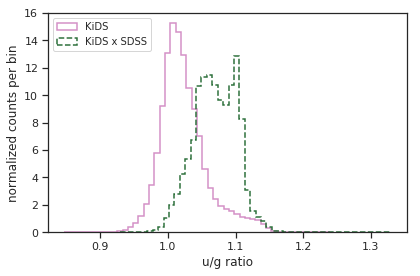

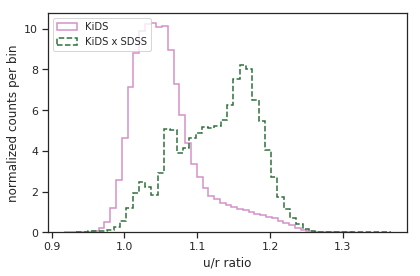

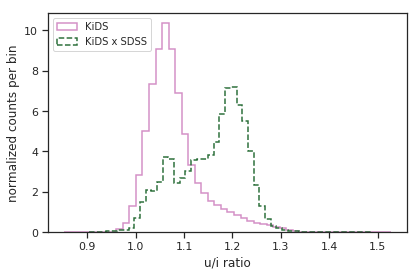

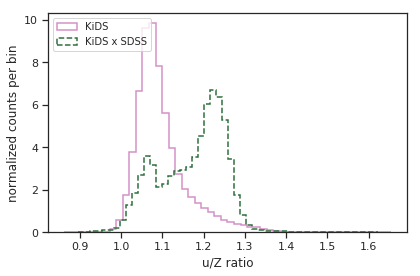

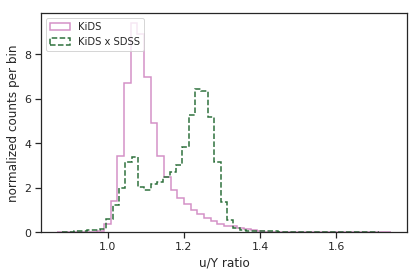

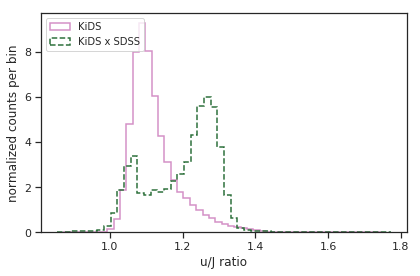

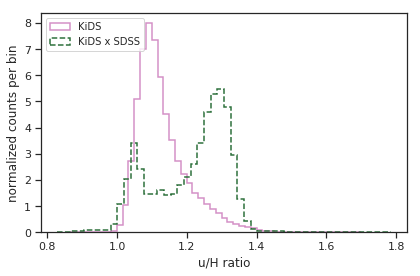

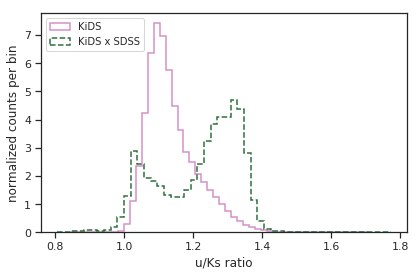

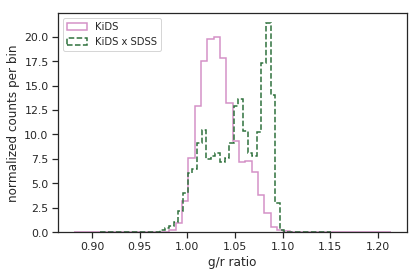

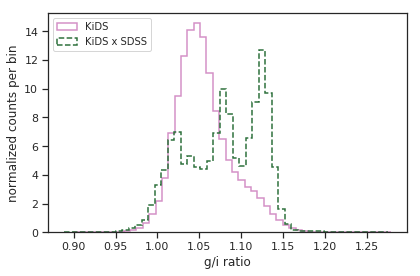

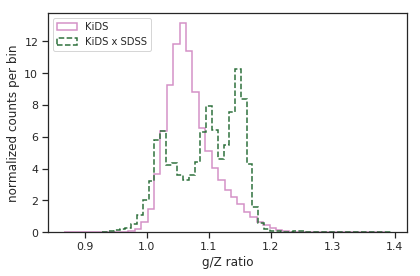

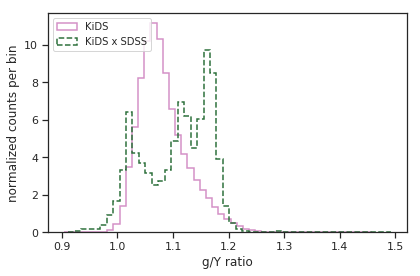

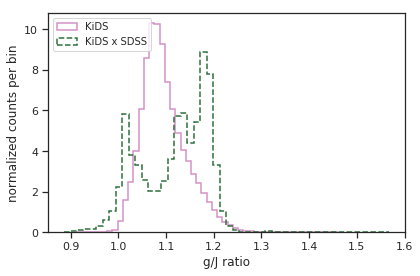

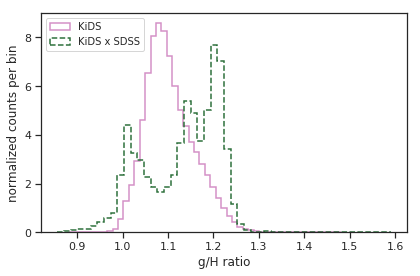

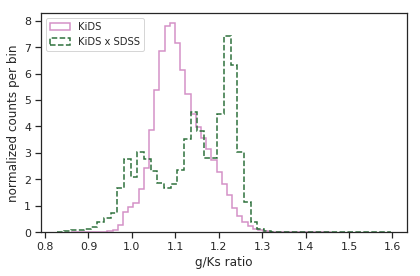

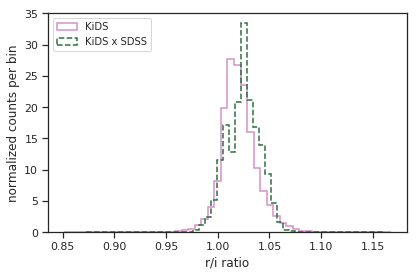

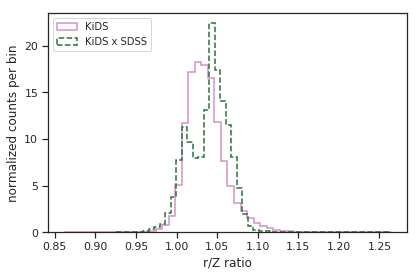

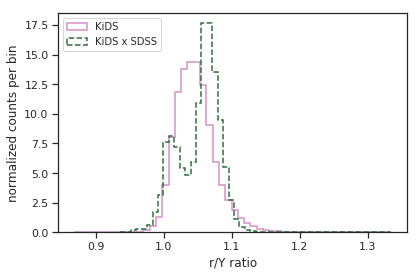

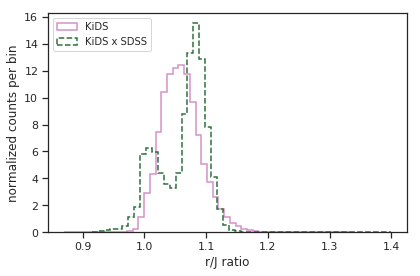

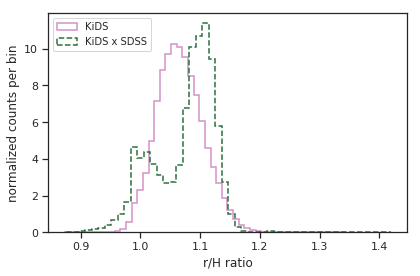

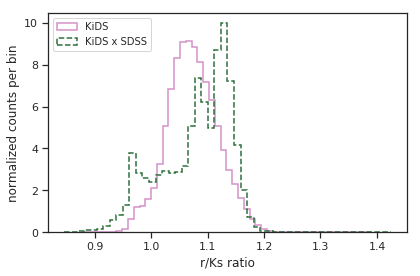

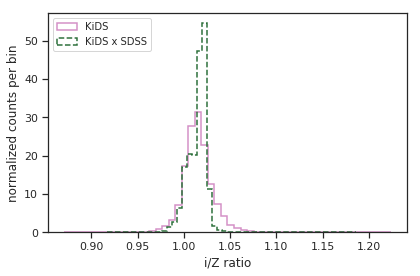

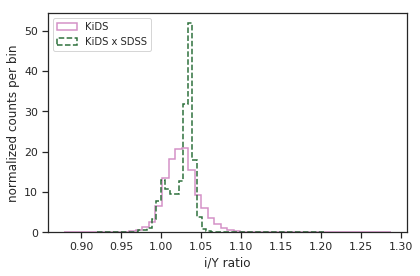

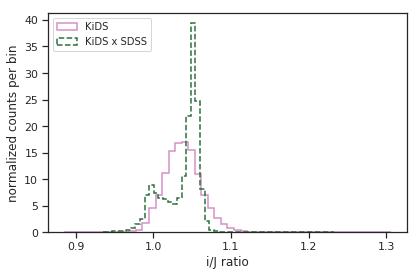

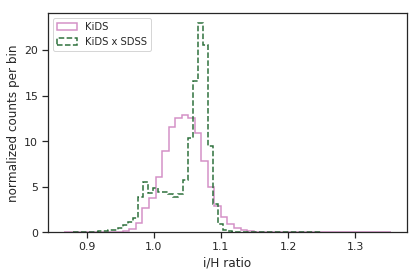

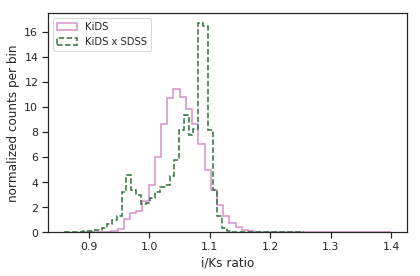

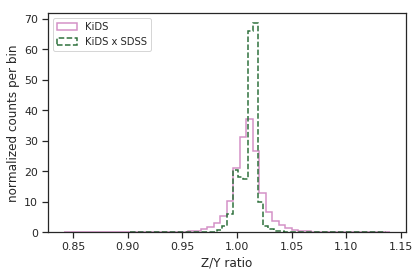

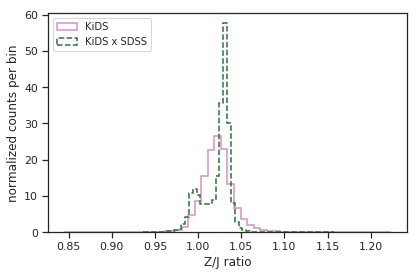

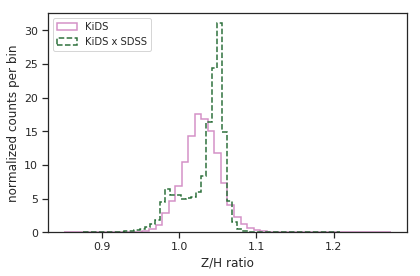

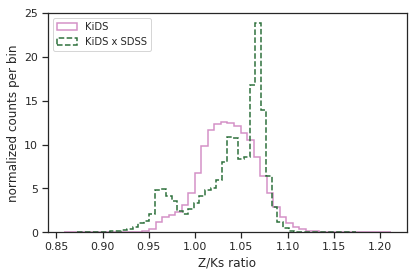

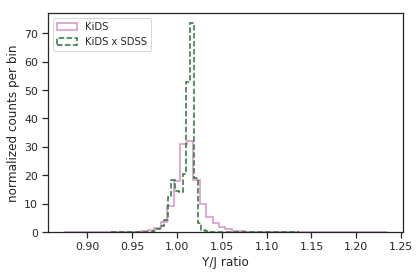

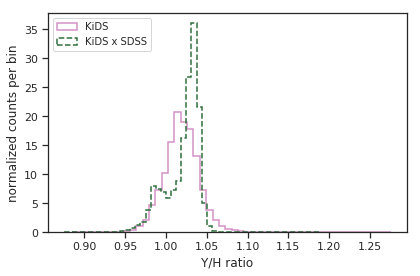

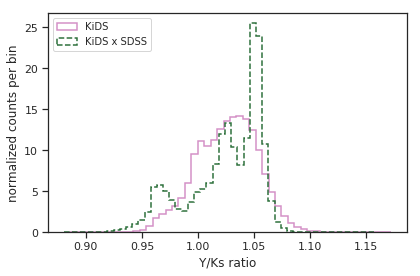

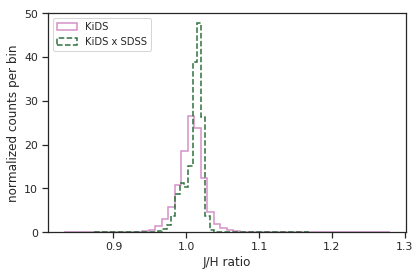

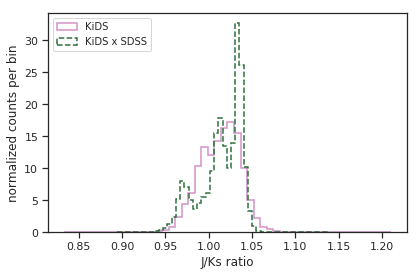

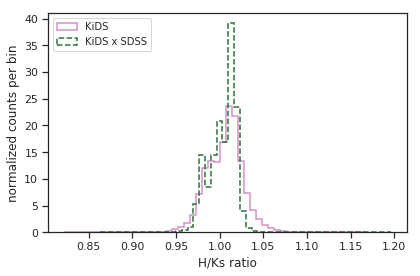

In [20]:
# Ratio histograms
data_dict = OrderedDict([('KiDS', kids), ('KiDS x SDSS', kids_x_sdss)])
plot_histograms(data_dict, RATIO_COLUMNS, legend_size=10, pretty_print_function=pretty_print_feature)

# t-SNE

In [24]:
def add_cut_label(data):
    data['cut_label'] = 'remaining'
#     data.loc[data[COLOR_GAAPHOM_U_G] < 0, 'cut_label'] = 'u-g cut'
    data.loc[data[get_mag_str('r')] > 22, 'cut_label'] = 'r cut'
#     data.loc[(data[MAG_GAAP_CALIB_R] > 22) & (data[COLOR_GAAPHOM_U_G] < 0), 'cut_label'] = 'both cuts'
    return data

In [39]:
kids_merged = kids.append(kids_x_sdss.loc[~kids['ID'].isin(kids_x_sdss['ID'])], sort=False)
kids_merged = add_cut_label(kids_merged)
kids_merged['is_in_SDSS'] = kids_merged['ID'].isin(kids_x_sdss['ID'])
kids_merged['CLASS'] = kids_merged['CLASS'].fillna(value='not SDSS')

In [40]:
kids_sampled = kids_merged.sample(20000, random_state=1467)

In [34]:
X = kids_sampled[FEATURES['all']]
X_scaled = MinMaxScaler().fit_transform(X)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype float32, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [35]:
X_embedded = TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0, learning_rate=200.0, n_iter=1000,
                  n_iter_without_progress=300, min_grad_norm=1e-07, metric='euclidean', init='random', verbose=0,
                  random_state=8934, method='barnes_hut', angle=0.5).fit_transform(X_scaled)

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


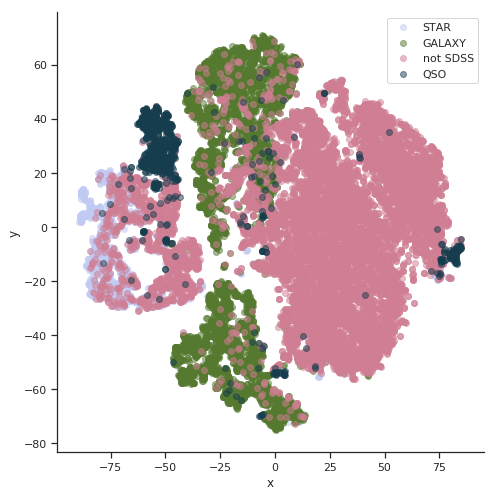

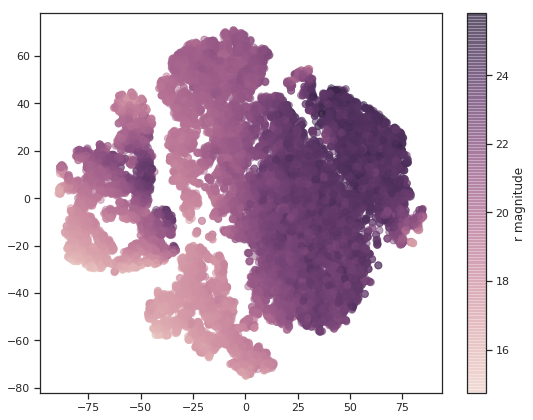

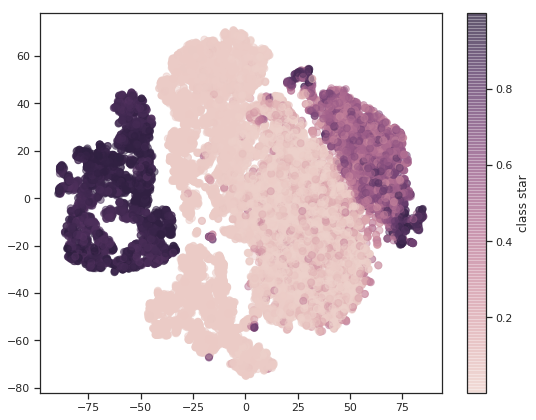

In [41]:
# Class plot
plot_embedding(X_embedded, kids_sampled['CLASS'], label='object type')

# Magnitude plot
plot_embedding(X_embedded, kids_sampled[get_mag_str('r')], label='r magnitude', is_continuous=True)

# Class star plot
plot_embedding(X_embedded, kids_sampled['CLASS_STAR'], label='class star', is_continuous=True)

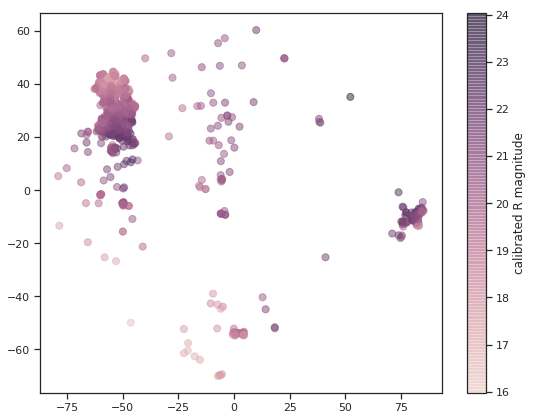

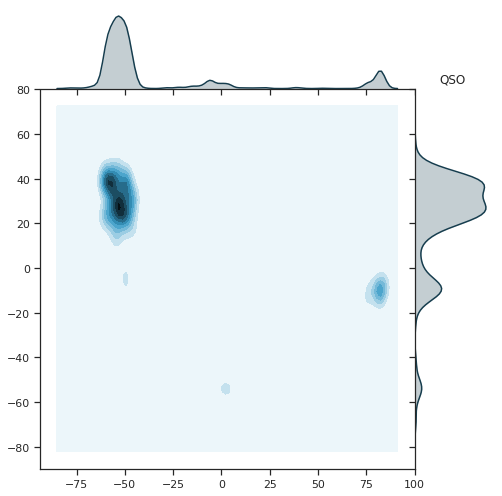

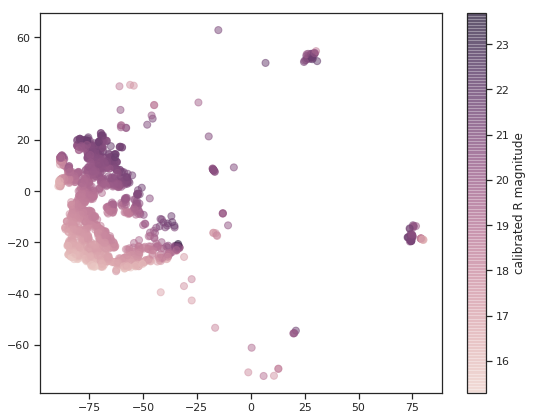

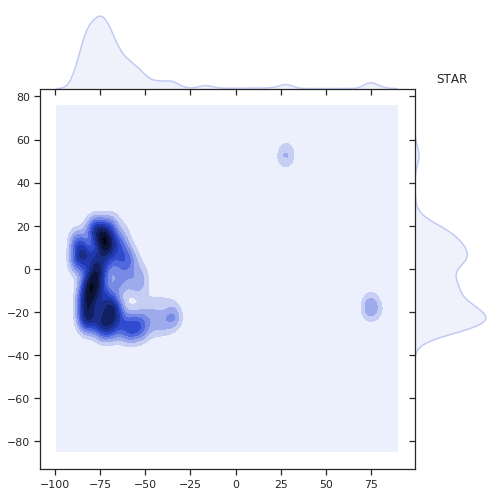

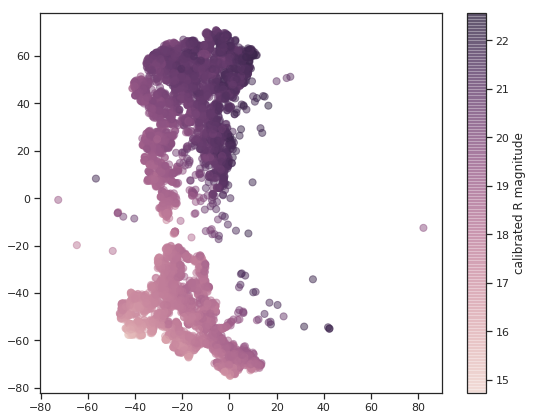

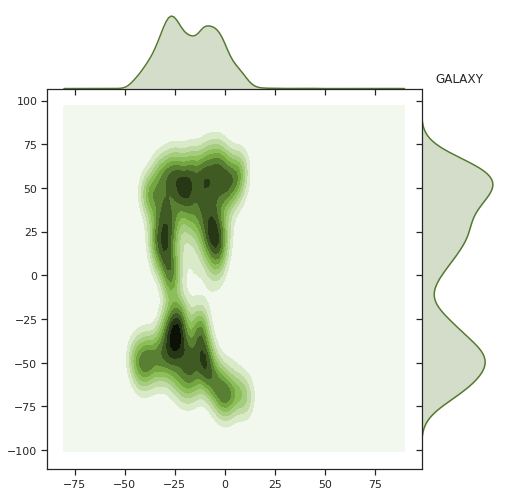

In [45]:
# Single class plots
for c in BASE_CLASSES:
    idx_class = (kids_sampled['CLASS'] == c)
    
    plot_embedding(X_embedded[idx_class], kids_sampled.loc[idx_class, MAG_GAAP_STR.format('r')],
                   label='calibrated R magnitude', is_continuous=True)
    
    sns.jointplot(X_embedded[idx_class][:, 0], X_embedded[idx_class][:, 1], kind='kde', height=7, space=0,
                 color=CUSTOM_COLORS[c])
    
    plt.title(c)

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


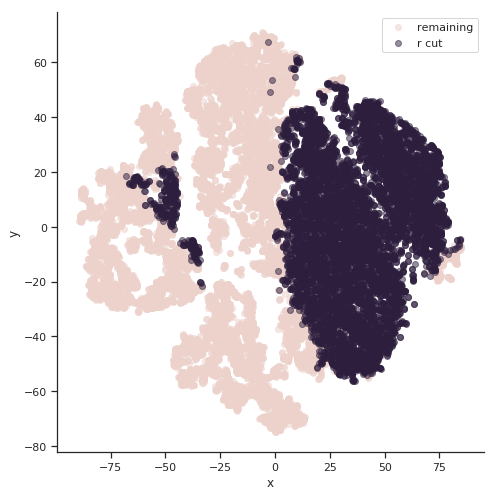

In [49]:
labels = kids_sampled['cut_label']

labels_unique = np.unique(labels)
n_colors = len(labels_unique)
color_palette = sns.cubehelix_palette(n_colors)
color_palette.reverse()

color_palette = OrderedDict([
    ('remaining', color_palette[1]),
    ('r cut', color_palette[0]),
])

plot_embedding(X_embedded, labels, label='data cut', color_palette=color_palette, with_custom_colors=False,
               labels_in_order=True)